$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\Tr}[0]{^\top}
\newcommand{\softmax}[1]{\mathrm{softmax}\left({#1}\right)}
$$

# CS236781: Deep Learning
# Tutorial 7: Enc/Dec Seq2Seq and Attention

## Introduction


In this tutorial, we will cover:

TODO

In [1]:
# Setup
%matplotlib inline
import os
import sys
import math
import time
import tqdm
import torch
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Attention Mechanisms

In the context of learning from **sequences** of inputs, we have seen RNNs as a model capable of learning a transformation of one sequence into another.

<center><img src="img/rnn_unrolled.png" width="1000" /></center>


Where,

$$
\begin{align}
\forall t \geq 0:\\
\vec{h}_t &= \varphi_h\left( \mat{W}_{hh} \vec{h}_{t-1} + \mat{W}_{xh} \vec{x}_t + \vec{b}_h\right) \\
\vec{y}_t &= \varphi_y\left(\mat{W}_{hy}\vec{h}_t + \vec{b}_y \right)
\end{align}
$$

However, RNNs (even the fancy ones) have some major drawbacks:

1. Input must be processed sequentially.
2. Hard to train on long sequences (needs BPTT).
3. Difficult to learn long-term dependencies, e.g. between late outputs and early inputs. The **hidden state** has the burden of "remembering" the "meaning" of the entire sequence so far.

Imagine we want to translate text from English to French. The general approach using RNNs is to design a Sequence-to-sequence (**Seq2Seq**) Encoder-Decoder architecture:

<center><img src="img/seq2seq.svg" width="1000" /></center>

In such an architecture the **last** hidden state must encode all the information the decoder needs for translation.

**Local** information, i.e. the encoder outputs and intermediate hidden states is discarded.

Can we use this local info to help the decoder?

### Definition

In deep learning contexts, **attention** is a term used for a family of related mechanisms which, in general, learn to predict some probability distribution over a sequence of elements.

Intuitively, this allows a model to "pay more attention" to elements from the sequence which get a higher probability.

Recent versions of attention mechanisms can be defined formally as follows:

Given:
- $n$ **key-value** pairs: $\left\{\left(\vec{k}_i, \vec{v}_i\right)\right\}_{i=1}^{n}$, where $\vec{k}_i\in\set{R}^{d_k}$, $\vec{v}_i\in\set{R}^{d_v}$
- A **query**, $\vec{q} \in\set{R}^{d_q}$
- Some similarity function between keys and queries, $s: \set{R}^{d_k}\times \set{R}^{d_q} \mapsto \set{R}$

An attention mechanism computes a weighted sum of the **values**,

$$
\vec{o} = \sum_{i=1}^{n} a_i \vec{v}_i\ \in \set{R}^{d_v},
$$

where attention weights $a_i$ are computed according the the similarity between the **query** and each **key**:

$$
\begin{align}
b_i &= s(\vec{k}_i, \vec{q}) \\
\vec{b} &= \left[  b_1, \dots, b_n \right]\Tr \\
\vec{a} &= \softmax{\vec{b}}.
\end{align}
$$


### Multiplicative attention

One basic type of attention mechanism uses a simple **dot product** as the similarity function.

Widely-used by models based on the **Transformer** architecture.

Assume $d_k=d_q=d$, then

$$
s(\vec{k},\vec{q})= \frac{\vectr{k}\vec{q}}{\sqrt{d}}.
$$

Why scale by $\sqrt{d}$ ?

It's the factor at which the dot-product grows due to the dimensionality. E.g.,

$$
\norm{\vec{1}_d}_2 = \norm{[1,\dots,1]\Tr}_2 = \sqrt{d\cdot 1^2} =\sqrt{d}.
$$

This helps keep the softmax values from becoming very small when the dimension is large, and therefore helps prevent tiny gradients.

Let's now deal with $m$ queries simultaneously by stacking them in a matrix $\mat{Q} \in \set{R}^{m\times d}$.

Similarly, we'll stack the keys and values in their own matrices, $\mat{K}\in\set{R}^{n\times d}$, $\mat{V}\in\set{R}^{n\times d_v}$.

Then we can compute the attention weights for all queries in parallel:

$$
\begin{align}
\mat{B} &= \frac{1}{\sqrt{d}} \mat{Q}\mattr{K}  \ \in\set{R}^{m\times n} \\
\mat{A} &= \softmax{\mat{B}},\ \mathrm{dim}=1 \\
\mat{O} &= \mat{A}\mat{V} \ \in\set{R}^{m\times d_v}.
\end{align}
$$

Note that the softmax is applied per-row, and so each row $i$ of $\mat{A}$ contains the attention weights for the $i$th query.

Also notice that in this formulation, we **input a sequence** of $m$ queries and get an **output sequence** of $m$ weighed values.

### Additive attention based on an MLP

Another common type of attention mechanism uses an MLP to **learn** the similarity function $s(\vec{k},\vec{q})$.

In this type of attention, the similarity function is 

$$
s(\vec{k},\vec{q}) = \vectr{v} \tanh(\mat{W}_k\vec{k} + \mat{W}_q\vec{q}),
$$

where $\mat{W}_k\in\set{R}^{h\times d_k}$, $\mat{W}_q\in\set{R}^{h\times d_q}$ and $\vec{v}\in\set{R}^{h}$ are trainable parameters.

- Notice that we're adding projected versions of the key and query and applying a 2-layer MLP.
- Both projections and the output layer are trainable.

## Example: Seq2Seq language translation

In [3]:
from torchtext.datasets import Multi30k
from torchtext.data import Field

# Common args for field objects
field_args = dict(tokenize='spacy',
                  init_token = '<sos>',
                  eos_token = '<eos>',
                  include_lengths=True,
                  lower = True) 

# Field for processing German source
src_field = Field(tokenizer_language="de_core_news_sm", **field_args)

# Field for processing English target
tgt_field = Field(tokenizer_language="en_core_web_sm", **field_args)

In [4]:
ds_train, ds_valid, ds_test = Multi30k.splits(
    root=data_dir, exts=('.de', '.en'), fields=(src_field, tgt_field)
)

VOCAB_MIN_FREQ = 2
src_field.build_vocab(ds_train, min_freq=VOCAB_MIN_FREQ)
tgt_field.build_vocab(ds_train, min_freq=VOCAB_MIN_FREQ)

In [5]:
V_src = len(src_field.vocab)
print(f'source vocab size: {V_src}')

V_tgt = len(tgt_field.vocab)
print(f'target vocab size: {V_tgt}')

source vocab size: 7855
target vocab size: 5893


In [6]:
for i in ([1, 10, 100, 1000]):
    example = ds_train[i]
    src = str.join(" ", example.src)
    tgt = str.join(" ", example.trg)
    print(f'sample#{i:04d}:\n\tDE: {src}\n\tEN: {tgt}\n')

sample#0001:
	DE: mehrere männer mit schutzhelmen bedienen ein antriebsradsystem .
	EN: several men in hard hats are operating a giant pulley system .

sample#0010:
	DE: eine ballettklasse mit fünf mädchen , die nacheinander springen .
	EN: a ballet class of five girls jumping in sequence .

sample#0100:
	DE: männliches kleinkind in einem roten hut , das sich an einem geländer festhält .
	EN: toddler boy in a red hat holding on to some railings .

sample#1000:
	DE: ein junger mann in einem weißen hemd , der tomaten schneidet .
	EN: a young man in a white shirt cutting tomatoes .



In [7]:
tgt_field.vocab.itos[0:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man']

In [8]:
src_field.vocab.itos[0:10]

['<unk>', '<pad>', '<sos>', '<eos>', '.', 'ein', 'einem', 'in', 'eine', ',']

In [9]:
UNK_TOKEN = tgt_field.vocab.stoi['<unk>']
PAD_TOKEN = tgt_field.vocab.stoi['<pad>']

print(f'<unk>={UNK_TOKEN}, <pad>={PAD_TOKEN}')

<unk>=0, <pad>=1


In [10]:
from torchtext.data import BucketIterator

BATCH_SIZE = 4
dl_train, dl_valid, dl_test = BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size = BATCH_SIZE)

In [11]:
# dataloader returns a Batch object with .src and .trg attributes
b0 = next(iter(dl_train))

# The .src/.trg attributes contain tuples of sequences and their lengths
# Get batches of sequences 
x0, x0_len = b0.src
y0, y0_len =  b0.trg

print('x0:\n', x0, x0.shape)
print('x0_len:\n', x0_len, x0_len.shape)
print('y0:\n', y0, y0.shape)
print('y0_len:\n', y0_len, y0_len.shape)

x0:
 tensor([[   2,    2,    2,    2],
        [   5,    8,    5,    8],
        [4401,   16,   13,   16],
        [  93,   11, 3474,   10],
        [ 337,  150,   19, 1021],
        [   8,  483,   80,  103],
        [1275,  159,  109,   65],
        [  12,    7,   57,   57],
        [  17,   14,   12,    7],
        [ 969,    0,   24,    6],
        [   7,    4,  433,    0],
        [ 374,    3,    4,    4],
        [  15,    1,    3,    3],
        [1474,    1,    1,    1],
        [   0,    1,    1,    1],
        [   4,    1,    1,    1],
        [   3,    1,    1,    1]]) torch.Size([17, 4])
x0_len:
 tensor([17, 12, 13, 13]) torch.Size([4])
y0:
 tensor([[   2,    2,    2,    2],
        [   4,    4,    4,    4],
        [3307,   14,    9,   14],
        [ 136,  130, 5724,   11],
        [ 454,   20,    4,  417],
        [4341,    4,   34,   70],
        [   4, 1072,   58,   63],
        [ 503,  379,  205,  128],
        [  68,   15,  137,    6],
        [  40,   22,   20, 2863],
 

In [12]:
import torch.nn as nn

class Seq2SeqEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, h_dim, dropout=0.2):
        super().__init__()
        
        # nn.Embedding converts from token index to dense tensor
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # PyTorch multilayer GRU RNN
        self.rnn = nn.GRU(embedding_dim, h_dim, num_layers=num_layers, dropout=dropout)
        
    def forward(self, x):
        # x shape: (S, B) Note batch dim is not first!
        S, B = x.shape
        embedded = self.embedding(x) # embedded shape: (S, B, E)
        
        # GRU second output returns last hidden state from each layer (L, B, H)
        _, ht = self.rnn(embedded)
        return ht

Test the encoder with a batch of English sentences

In [13]:
EMB_DIM = 128
HID_DIM = 64
NUM_LAYERS = 2

enc = Seq2SeqEncoder(V_src, EMB_DIM, NUM_LAYERS, HID_DIM)
ht = enc(x0)
print(ht, ht.shape)

tensor([[[ 1.5583e-02, -3.4762e-01,  6.2976e-01,  1.7246e-01,  6.8432e-01,
          -1.9763e-01, -5.1883e-01, -6.2466e-02,  3.4721e-01, -1.4541e-01,
           4.4780e-01,  3.3496e-01,  4.6464e-01,  4.6683e-01, -3.6345e-01,
           1.3245e-03, -2.1402e-02,  3.5455e-01, -7.5773e-02, -4.7292e-01,
          -5.7283e-01,  6.9557e-01,  3.5250e-01, -5.5624e-02,  3.7981e-01,
          -1.9507e-01, -5.1720e-01,  3.8117e-01, -8.8375e-02, -7.9075e-02,
           1.8843e-01,  8.4808e-02,  4.5000e-01, -3.6539e-01, -2.4423e-01,
          -1.5043e-01,  5.4706e-01,  2.7949e-01,  1.3371e-01,  7.9700e-02,
           6.1545e-02,  1.9213e-01,  2.2786e-01, -7.0082e-01, -1.3605e-01,
          -1.2753e-01,  4.2250e-01,  2.6757e-01, -1.3597e-01, -6.7624e-01,
          -5.1920e-01,  9.4097e-02,  5.2347e-01,  1.4280e-01,  6.6536e-01,
          -8.7782e-02, -2.2789e-01,  4.3113e-01,  2.9795e-01,  3.9550e-01,
          -4.3588e-01, -8.4631e-02,  2.9880e-02, -1.3798e-01],
         [ 5.4220e-01,  2.4791e-01, -

In [14]:
class Seq2SeqDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, h_dim, dropout=0.2):
        super().__init__()
        
        # nn.Embedding converts from token index to dense tensor
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # PyTorch multilayer GRU RNN
        self.rnn = nn.GRU(embedding_dim, h_dim, num_layers=num_layers, dropout=dropout)
        
        # Output layer, note the output dimension!
        self.out_fc = nn.Linear(h_dim, vocab_size)
        
    def forward(self, x, context):
        # x shape: (S, B)
        # context: (L, B, H) the last hidden state from the encoder
        S, B = x.shape
        embedded = self.embedding(x) # embedded shape: (S, B, E)
        
        # Note initial hidden state is the input context vector
        # GRU first output returns all hidden states from last layer (S, B, H)
        h, ht = self.rnn(embedded, context)
        
        # Project H back to the vocab size V, to get a score per word
        out = self.out_fc(h)
        
        # Out shapes: (S, B, V) and (L, B, H)
        return out, ht

Test the decoder with the corresponding batch of German sentences

In [15]:
dec = Seq2SeqDecoder(V_tgt, EMB_DIM, NUM_LAYERS, HID_DIM)
yhat, _ = dec(y0, ht) # note different S
print(yhat, yhat.shape)

tensor([[[-0.0098,  0.0469,  0.0229,  ..., -0.0146, -0.1563,  0.0690],
         [ 0.1325, -0.1032,  0.0760,  ..., -0.0694, -0.0042,  0.1127],
         [ 0.1405, -0.1850,  0.0218,  ..., -0.0577, -0.0264,  0.1566],
         [ 0.1133, -0.0429,  0.0945,  ..., -0.1002, -0.0891,  0.1303]],

        [[ 0.0092, -0.0267,  0.1154,  ..., -0.0876, -0.2366,  0.0273],
         [ 0.0703, -0.0183,  0.1676,  ..., -0.1077, -0.1327,  0.1716],
         [ 0.0537, -0.0792,  0.1641,  ..., -0.1646, -0.1824,  0.1715],
         [ 0.0277,  0.0269,  0.2046,  ..., -0.1804, -0.1919,  0.1667]],

        [[ 0.0309, -0.0517,  0.0193,  ..., -0.0923, -0.3503,  0.0255],
         [ 0.0475, -0.0988,  0.1023,  ..., -0.1581, -0.2797,  0.1908],
         [ 0.0738, -0.0205,  0.1792,  ..., -0.0810, -0.2381,  0.1136],
         [ 0.0307, -0.0790,  0.1502,  ..., -0.1874, -0.2777,  0.1220]],

        ...,

        [[-0.1867, -0.1176,  0.0830,  ..., -0.0247, -0.0263,  0.1567],
         [ 0.1750, -0.0260,  0.0926,  ..., -0.1519, -0.13

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embedding_dim, num_layers, h_dim, **kw):
        super().__init__()
        
        # Create encoder & decoder parts
        self.enc = Seq2SeqEncoder(src_vocab_size, embedding_dim, num_layers, h_dim, **kw)
        self.dec = Seq2SeqDecoder(tgt_vocab_size, embedding_dim, num_layers, h_dim, **kw)
    
    def forward(self, x_src, x_tgt, p_tf=1.):
        # input shapes: (S1, B), (S2, B)
        S2, B = x_tgt.shape
        
        # Forward pass through encoder
        # context is (L, B, H)
        context = self.enc(x_src)
        
        # First input is first target token
        dec_input = x_tgt[[0], :] # (1, B)
        # Loop over tokens in target sequence and feed them to the decoder
        dec_outputs = []
        for t in range(1, S2):
            # Feed the decoder sequences of length 1
            dec_output, context = self.dec(dec_input, context) # dec_output is (1, B, V)
            dec_outputs.append(dec_output)
            
            # For next input, take either:
            # - next target token (AKA "teacher forcing"), with proba p_tf
            # - highest scoring output (greedy prediction of next token), with proba 1-p_tf
            if p_tf > torch.rand(1).item():
                dec_input = x_tgt[[t], :] # (1, B)
            else:
                dec_input = torch.argmax(dec_output, dim=2) # (1,B,V) -> (1, B)
            
        # Stack decoder outputs from all timesteps
        y_hat = torch.cat(dec_outputs, dim=0) # (S-1)x(1,B,V) -> (S-1,B,V)
        
        # Output shape: (S-1, B, V)
        return y_hat

In [17]:
seq2seq_model = Seq2Seq(V_src, V_tgt, EMB_DIM, NUM_LAYERS, HID_DIM)
yhat = seq2seq_model(x0, y0)
print(yhat.shape)

torch.Size([16, 4, 5893])


In [18]:
from torchsummaryX import summary
summary(seq2seq_model, x0, y0);

                           Kernel Shape  Output Shape    Params  Mult-Adds
Layer                                                                     
0_enc.Embedding_embedding   [128, 7855]  [17, 4, 128]  1.00544M    1005440
1_enc.GRU_rnn                         -   [17, 4, 64]   62.208k      61440
2_dec.Embedding_embedding   [128, 5893]   [1, 4, 128]  754.304k     754304
3_dec.GRU_rnn                         -    [1, 4, 64]   62.208k      61440
4_dec.Linear_out_fc          [64, 5893]  [1, 4, 5893]  383.045k     377152
5_dec.Embedding_embedding   [128, 5893]   [1, 4, 128]         -     754304
6_dec.GRU_rnn                         -    [1, 4, 64]         -      61440
7_dec.Linear_out_fc          [64, 5893]  [1, 4, 5893]         -     377152
8_dec.Embedding_embedding   [128, 5893]   [1, 4, 128]         -     754304
9_dec.GRU_rnn                         -    [1, 4, 64]         -      61440
10_dec.Linear_out_fc         [64, 5893]  [1, 4, 5893]         -     377152
11_dec.Embedding_embeddin

In [19]:
def train_seq2seq(model, dl_train, optimizer, loss_fn, p_tf=1., clip_grad=1., max_batches=None):
    losses = []
    with tqdm.tqdm(total=(max_batches if max_batches else len(dl_train)), file=sys.stdout) as pbar:
        for idx_batch, batch in enumerate(dl_train, start=1):
            x, x_len = batch.src
            y, y_len =  batch.trg

            # Forward pass: encoder and decoder
            # Output y_hat is the translated sequence
            y_hat = model(x, y, p_tf)
            S, B, V = y_hat.shape

            # y[:,i] is <sos>, w_1, w_2, ..., w_k, <eos>, <pad>, ...
            # y_hat is   w_1', w_2', ..., w_k', <eos>', <pad>', ...
            # based on the above, get grout truth y
            y_gt = y[1:, :].reshape(S*B)  # drop <sos>
            y_hat = y_hat.reshape(S*B, V)

            # Calculate loss compared to ground truth y
            optimizer.zero_grad()
            loss = loss_fn(y_hat, y_gt)
            loss.backward()

            # Prevent exploding gradients
            if clip_grad > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            # Update parameters
            optimizer.step()

            losses.append(loss.item())
            pbar.update(); pbar.set_description(f'train loss={losses[-1]:.3f}')
            if max_batches and idx_batch >= max_batches:
                break
    return losses

In [20]:
def eval_seq2seq(model, dl_test):
    accuracies = []
    with tqdm.tqdm(total=len(dl_test), file=sys.stdout) as pbar:
        for idx_batch, batch in enumerate(dl_test):
            x, x_len = batch.src
            y, y_len =  batch.trg

            with torch.no_grad():
                y_hat = model(x, y, p_tf=0)  # Note: no teacher forcing

            S, B, V = y_hat.shape

            y_gt = y[1:, :].reshape(S*B)  # drop <sos>
            y_hat = torch.argmax(y_hat.reshape(S*B, V), dim=1) # greedy-sample

            # Compare prediction to ground truth
            accuracies.append(torch.sum(y_gt == y_hat) / S)

            pbar.update(); pbar.set_description(f'eval acc={accuracies[-1]}')
    return accuracies

In [45]:
BATCH_SIZE = 128
# Use small model so that training is fast, just an example
EMB_DIM = 64
HID_DIM = 128
NUM_LAYERS = 2
GRAD_CLIP = 1.
EPOCHS = 2
BATCHES_PER_EPOCH=25

dl_train, dl_valid, dl_test = BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE)
seq2seq_model = Seq2Seq(V_src, V_tgt, EMB_DIM, NUM_LAYERS, HID_DIM)

optimizer = torch.optim.Adam(seq2seq_model.parameters(), lr=1e-3)

# Note: We don't compute loss from padding tokens!
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

losses = []
accuracies = []
for idx_epoch in range(EPOCHS):
    # Linearly decay amount of teacher forcing fro the first 10 epochs (example)
    p_tf = 1 - min((idx_epoch / 20), 1)
    
    print(f'=== EPOCH {idx_epoch+1}/{EPOCHS}, p_tf={p_tf:.2f} ===')
    losses += train_seq2seq(seq2seq_model, dl_train, optimizer, loss_fn, p_tf, GRAD_CLIP, BATCHES_PER_EPOCH)
    accuracies += eval_seq2seq(seq2seq_model, dl_valid)

=== EPOCH 1/2, p_tf=1.00 ===
eval acc=7: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s] 
=== EPOCH 2/2, p_tf=0.95 ===
eval acc=7: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s] 


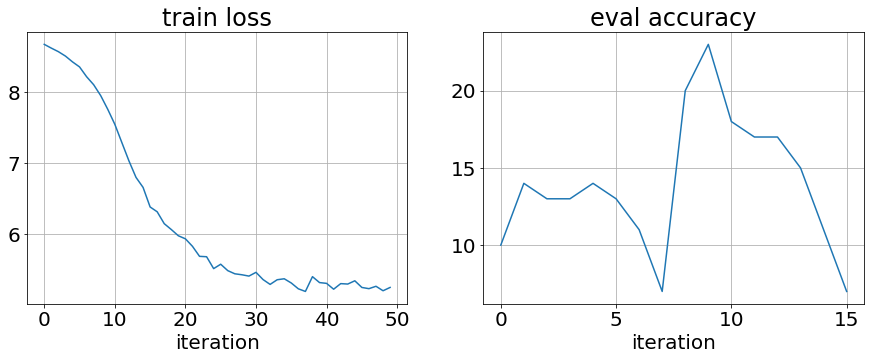

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
ax[1].plot(accuracies); ax[1].set_title('eval accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)

In [23]:
losses

[8.515604019165039,
 8.48193645477295,
 8.46484088897705,
 8.419981002807617,
 8.402544975280762,
 8.356700897216797,
 8.316434860229492,
 8.299473762512207,
 8.261879920959473,
 8.202543258666992]

**Image credits**

Some images in this tutorial were taken and/or adapted from:

- Zhang et al., Dive into Deep Learning, 2019
- Fundamentals of Deep Learning, Nikhil Buduma, Oreilly 2017
- Andrej Karpathy, http://karpathy.github.io
- MIT 6.S191
- Stanford cs231n
- K. Xu et al. 2015, https://arxiv.org/abs/1502.03044